In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

## Citation

```
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}
```

Also, all thanks to Kylie Ying for the CNN course and this model. https://www.youtube.com/watch?v=nVhau51w6dM


# Data
TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [2]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True) #tensor flow load 'food101' data set 

In [3]:
train_ds, valid_ds = ds["train"], ds["validation"]

2024-06-24 21:03:47.131503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


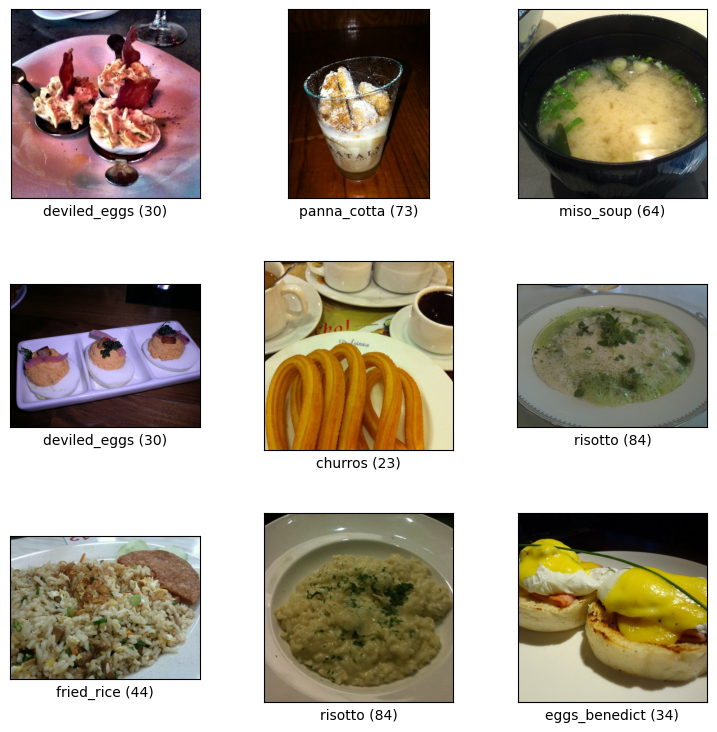

In [4]:
fig = tfds.show_examples(train_ds, ds_info)

In [5]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), #lambda: what are the inputs
                          tf.cast(label == HOT_DOG_CLASS, tf.int32)) # whether or not is hot dog class 
)

valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), #lambda: what are the inputs
                          tf.cast(label == HOT_DOG_CLASS, tf.int32)) # whether or not is hot dog class 
)


2024-06-24 21:03:48.304009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


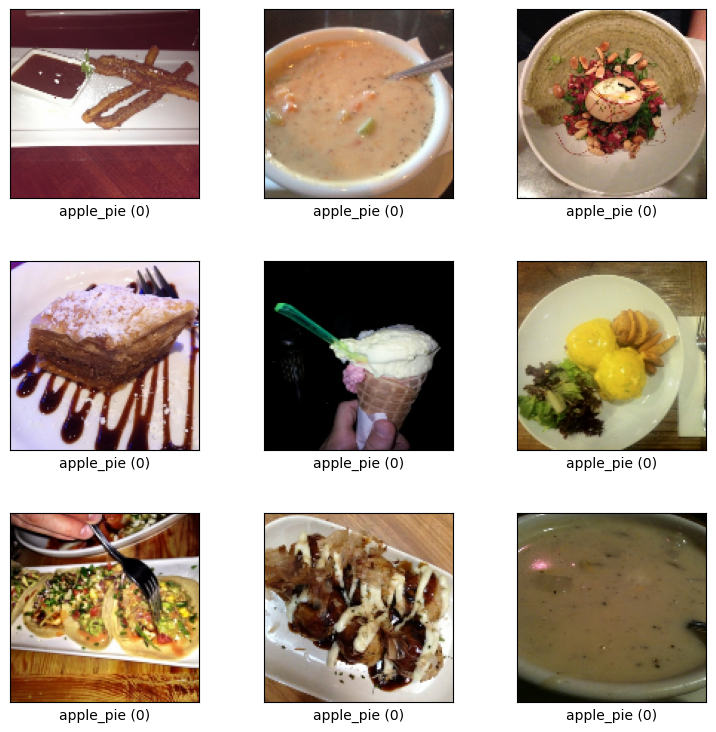

In [6]:
fig = tfds.show_examples(train_ds, ds_info)

In [7]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [8]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [9]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch)
    print(label_batch)

tf.Tensor(
[[[[ 67  30  13]
   [ 74  39  12]
   [149 118  84]
   ...
   [238 194 163]
   [221 176 149]
   [150 106  83]]

  [[ 65  32   8]
   [ 69  34   3]
   [ 79  44   9]
   ...
   [112  68  35]
   [148 108  77]
   [175 136 104]]

  [[134 100  58]
   [117  79  34]
   [ 83  45   3]
   ...
   [214 189 167]
   [229 201 173]
   [191 157 121]]

  ...

  [[198  67  14]
   [206  75  19]
   [202  72  16]
   ...
   [225 174 116]
   [224 172 116]
   [227 172 118]]

  [[201  72  14]
   [204  76  16]
   [198  69  11]
   ...
   [226 172 115]
   [224 174 115]
   [224 172 114]]

  [[202  74  12]
   [203  75  12]
   [201  73  13]
   ...
   [223 169 114]
   [223 172 115]
   [224 173 116]]]


 [[[213 213 205]
   [212 212 204]
   [209 209 201]
   ...
   [ 34  26  21]
   [ 30  23  17]
   [ 30  23  17]]

  [[215 215 207]
   [211 211 203]
   [210 210 202]
   ...
   [ 23  17  13]
   [ 24  17  14]
   [ 27  19  16]]

  [[215 215 207]
   [213 213 205]
   [209 209 201]
   ...
   [ 24  22  17]
   [ 24  19  16]


2024-06-24 21:03:49.800932: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-24 21:03:49.843162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Neural Net Implementation

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [12]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
model.save('model/model.h5') # this is bad model 

